# Imports

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import json
import seaborn as sns
import plotly.figure_factory as ff
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import plotly.graph_objects as go
from tensorflow.keras.layers import Dense, Activation,Flatten,Conv2D,Dropout,MaxPooling2D,AveragePooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2, EfficientNetB7, ConvNeXtBase
from tqdm.notebook import tqdm
from pathlib import Path
import cv2
from PIL import Image 
import warnings 
warnings.filterwarnings('ignore')

In [15]:
import platform

In [16]:
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.13.0


In [17]:
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.4.1-arm64-arm-64bit
Tensor Flow Version: 2.13.0

GPU is available


# Load Data

In [18]:
train_data = pd.read_csv('./data/train.csv')
train_data = shuffle(train_data,random_state = 0)
train_data['label'] = pd.Series(train_data['label'], dtype="string")
train_data

,image_id,label
18634,483986538.jpg,3
1086,1186910590.jpg,4
14439,35835458.jpg,3
15301,3750000354.jpg,4
19761,689866725.jpg,3
...,...,...
13123,3349562972.jpg,3
19648,669748740.jpg,3
9845,2750295170.jpg,3
10799,2925605732.jpg,1


In [19]:
label_names = open('./data/label_num_to_disease_map.json')
label_names = json.load(label_names)
label_names

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [20]:
train_data["Classification"] = train_data["label"].apply(lambda x: label_names.get(x))
train_data

,image_id,label,Classification
18634,483986538.jpg,3,Cassava Mosaic Disease (CMD)
1086,1186910590.jpg,4,Healthy
14439,35835458.jpg,3,Cassava Mosaic Disease (CMD)
15301,3750000354.jpg,4,Healthy
19761,689866725.jpg,3,Cassava Mosaic Disease (CMD)
...,...,...,...
13123,3349562972.jpg,3,Cassava Mosaic Disease (CMD)
19648,669748740.jpg,3,Cassava Mosaic Disease (CMD)
9845,2750295170.jpg,3,Cassava Mosaic Disease (CMD)
10799,2925605732.jpg,1,Cassava Brown Streak Disease (CBSD)


# EDA

In [ ]:
label_count = train_data.groupby('label', as_index=False).count()
label_count.rename(columns={'image_id': 'Count', 'label': 'Label'}, inplace=True)
label_count['Label'] = label_count['Label'].apply(lambda x: label_names[x])

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
font1 = {'family': 'Times New Roman','weight': 'bold','style':'normal','size': 20}
ax.set_xlabel('Type of disease',font1)
ax.set_ylabel('Count',font1)
ax = sns.barplot(x=label_count['Count'], y=label_count['Label'], palette='viridis')
ax.tick_params(labelsize=16)

In [ ]:
def show_image(image_ids, labels):
    plt.figure(figsize=(15, 9))
    
    for i, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, i + 1)
        try:
            img = cv2.imread(os.path.join('./data/train_images', image_id))
            if img is None:
                raise FileNotFoundError(f"Image not found: {image_id}")
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title(f"Class: {label}", fontsize=12)
            plt.axis("off")
        except Exception as e:
            # Handle the error gracefully
            print(f"Error loading image '{image_id}': {e}")
    
    plt.show()

samples = train_data.sample(9, random_state=0)
image_ids = samples['image_id'].values
labels = samples['Classification'].values

show_image(image_ids, labels)


In [ ]:
def load_img(path):
    try:
        img_bgr = cv2.imread(path)
        img_rgb = img_bgr[:, :, ::-1]
        return img_rgb
    except Exception as e:
        print(f"Error loading image '{path}': {e}")
        return None

# explore the pixels of cassava leaf pictures
img_folder = Path('data/train_images')
if img_folder.exists():
    img_names = img_folder.glob('*')
    plt.figure(figsize=(12, 8), dpi=800)
    pbar = tqdm(img_names, total=len(train_data))
    for img_name in pbar:
        img = load_img(img_name.as_posix())
        if img is not None:
            # here use the calchist method in cv2 to show the histogram of photo pixels
            hist = cv2.calcHist([img], [0], None, [256], [0, 256])
            plt.plot(hist)
        else:
            print(f"Skipping image: '{img_name}'")
    plt.show()
else:
    print('Directory containing images does not exist.')

## Healthy & Cassava Leaf Visualization

In [ ]:
Healthy_Cassava = train_data[train_data['Classification'] == 'Healthy']['image_id'].to_list()

CMD_Cassava = train_data[train_data['Classification'] == 'Cassava Mosaic Disease (CMD)']['image_id'].to_list()

In [ ]:
np.random.seed(20239417)

base_path = Path('data')
train_img_dir =  base_path/'train_images'

random_images=[]
plt.figure(figsize=(16,12))
for i in range(9):
    random_images.append(np.random.choice(Healthy_Cassava))

for i in range(9): 
    plt.subplot(3, 3, i + 1)
    img = plt.imread(train_img_dir/random_images[i])
    plt.imshow(img)
plt.show() 

In [ ]:
f = plt.figure(figsize=(16,8))
f.add_subplot(1,2, 1)

font2 = {'family': 'Times New Roman','weight': 'bold','style':'normal','size': 14}
raw_image = plt.imread(train_img_dir/Healthy_Cassava[2])
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Healthy Image',font2)
print(f"Image dimensions:  {raw_image.shape[0],raw_image.shape[1]}")
print(f"Maximum pixel value : {raw_image.max():.1f} ; Minimum pixel value:{raw_image.min():.1f}")
print(f"Mean value of the pixels : {raw_image.mean():.1f} ; Standard deviation : {raw_image.std():.1f}")

f.add_subplot(1,2, 2)
#  plt.hist(raw_image[:, :, 0].ravel(), bins=256, color='red', alpha=0.5): This line creates a histogram for the red channel of the image (raw_image) and 
# visualizes the pixel intensity distribution. It uses raw_image[:, :, 0] to extract the red channel of the image, and 
# ravel() is used to flatten the 2D array into a 1D array (necessary for plotting the histogram). 
# The bins=256 parameter specifies that the histogram will have 256 bins, which means that the intensity values will be grouped into 256 intervals. 
# The color='red' parameter sets the color of the histogram to red, and alpha=0.5 sets the transparency of the histogram to 50%, making it semi-transparent.
plt.hist(raw_image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
plt.hist(raw_image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
plt.hist(raw_image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
plt.xlabel('Intensity Value',font2)
plt.ylabel('Count',font2)
plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

In [ ]:
imageArray = []
for i in range(len(Healthy_Cassava)):
    try:
        img = cv2.imread(str(train_img_dir / Healthy_Cassava[i]))
        if img is not None:
            imageArray.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            print(f"Failed to load image: {train_img_dir / Healthy_Cassava[i]}")
    except Exception as e:
        print(f"Error loading image: {train_img_dir / Healthy_Cassava[i]} - {e}")

red_values = []
green_values = []
blue_values = []
values = []

for i in range(len(imageArray)):
    red_values.append(np.mean(imageArray[i][:, :, 0]))
    green_values.append(np.mean(imageArray[i][:, :, 1]))
    blue_values.append(np.mean(imageArray[i][:, :, 2]))
    values.append(np.mean(imageArray[i]))

hist_data = [red_values, green_values, blue_values, values]
group_labels = ['Red', 'Green', 'Blue', 'All']

fig = ff.create_distplot(hist_data, group_labels,colors = ['red', 'green','blue','grey'])
fig.update_layout(template = 'plotly_white', title_text = 'Channel Distribution - Healthy')
fig.show()

In [ ]:
figData = []
for i, name in zip(range(3), ['Red', 'Green', 'Blue']):
    trace = go.Box(y = hist_data[i], name = name, boxpoints='all', marker_color  = name)
    figData.append(trace)

fig = go.Figure(figData)
fig.update_layout(title_text = 'Pixel Intensity Distribution - health leaf', template = 'plotly_white')
fig.show() 

# Modelling

In [21]:
IMAGE_SIZE = 224
BATCH_SIZE = 128

In [22]:
train_data["label"] = train_data["label"].astype(str)

## Data Augmentation

In [23]:
train_data_gen = ImageDataGenerator(
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2,
    shear_range = 0.2, 
    zoom_range = 0.2,    
    horizontal_flip = True, 
    vertical_flip = True,
    validation_split = 0.2,
    fill_mode = 'nearest')

val_data_gen = ImageDataGenerator(validation_split = 0.2)

In [24]:
train_df_iter = train_data_gen.flow_from_dataframe(
    dataframe=train_data, directory = "data/train_images", seed = 0, x_col = "image_id", y_col = "label", interpolation = 'nearest', 
    target_size = (IMAGE_SIZE, IMAGE_SIZE), class_mode = "categorical", batch_size = BATCH_SIZE, shuffle = True, subset = "training")

Found 17118 validated image filenames belonging to 5 classes.


In [25]:
val_df_iter = val_data_gen.flow_from_dataframe(
    dataframe=train_data, directory = "data/train_images", seed = 0, x_col = "image_id",y_col = "label", interpolation = 'nearest', 
    target_size = (IMAGE_SIZE, IMAGE_SIZE), class_mode = "categorical", batch_size = BATCH_SIZE, shuffle = True, subset = "validation")

Found 4279 validated image filenames belonging to 5 classes.


In [26]:
train_data["label"].head()

18634    3
1086     4
14439    3
15301    4
19761    3
Name: label, dtype: object

The choice between Categorical Cross Entropy and Sparse Categorical Cross Entropy depends on how the class labels are represented:

Categorical Cross Entropy (Softmax Cross Entropy):

    Used when class labels are one-hot encoded.
    The model's output has the same number of units as the number of classes, and each unit's activation represents the probability of the input belonging to that class.
    The true labels are provided in one-hot encoded format, where only one element is 1, and the rest are 0s.
    Appropriate when there are a small number of classes or memory is not a concern.

Sparse Categorical Cross Entropy:

    Used when class labels are represented as integers (e.g., 0, 1, 2, etc.).
    The model's output still has the same number of units as the number of classes, but the true labels are provided as integers instead of one-hot encoded arrays.
    The integer class labels directly specify the class of each input sample.
    Appropriate when there are a large number of classes, and one-hot encoding of labels might be memory-intensive.

In our case, train_data dataframe's "label" column contains integer class labels (e.g., 0, 1, 2, etc.), so we can use Sparse Categorical Cross Entropy as the loss function. It will work effectively and avoid the overhead of one-hot encoding the labels.

## Loss function

In [14]:
optimizer = Adam(lr=0.00105)
model_loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False, 
                                                     label_smoothing=0.0001, 
                                                     name='categorical_crossentropy')

In [15]:
NCLASSES = 5

In [ ]:
MobileNetV2

In [25]:
def custom_model_with_base_MobileNetV2():
    conv_base = ConvNeXtBase( 
        include_top = False, 
        weights = 'None',
        input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
        pooling='avg')
    conv_base.trainable = False
    model = conv_base.output
    model = layers.GlobalAveragePooling2D()(model)
    model = BatchNormalization()(model)
    model = layers.Dense(NCLASSES, activation = "softmax")(model)
    model = Model(conv_base.input, model)
    model.compile(optimizer = Adam(lr = 0.01),
                  loss = "categorical_crossentropy",
                  metrics = ['acc'])
    return model

In [26]:
my_model = custom_model_with_base_MobileNetV2()

In [35]:
my_model.save('weights/my_model_pretrained_fintuned.h5')

In [3]:
my_model = tf.keras.saving.load_model('weights/my_model_pretrained_fintuned.h5')

2023-07-24 15:00:40.685720: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-07-24 15:00:40.685780: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-07-24 15:00:40.685791: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-07-24 15:00:40.686196: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-24 15:00:40.686501: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:

print('Our Model has %d layers' %len(my_model.layers))

Our Model has 157 layers


In [21]:
STEPS_PER_EPOCH  = len(train_data)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_data)*0.2 / BATCH_SIZE

## Training Configurations

In [27]:
reduce_lr = ReduceLROnPlateau(  monitor='val_loss', 
                                factor=0.2,
                                patience=2, 
                                min_lr=1e-6, 
                                mode='min', 
                                verbose=1)

early_stopping = EarlyStopping(monitor = "val_loss", 
                               mode = "min", 
                               patience = 2, 
                               restore_best_weights=True, 
                               verbose= 1)

check_point = ModelCheckpoint( "Cassava_Leaf_Disease_Detection_MobileNetV2_BestModel.h5", 
                                monitor = 'val_loss',
                                mode = 'min', 
                                save_best_only=True,
                                save_weights_only=True)

In [28]:
history = my_model.fit(
    train_df_iter,
    steps_per_epoch = STEPS_PER_EPOCH,
    validation_data = val_df_iter,
    validation_steps = VALIDATION_STEPS,
    epochs = 10, 
    callbacks = [early_stopping, reduce_lr, check_point]
)

Epoch 1/10


2023-07-24 12:26:51.086538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


134/133 [==============================] - ETA: 0s - loss: 1.3886 - acc: 0.5744

2023-07-24 12:31:22.430362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


133/133 [==============================] - 312s 2s/step - loss: 1.3886 - acc: 0.5744 - val_loss: 1.4234 - val_acc: 0.6242 - lr: 0.0100
Epoch 2/10
133/133 [==============================] - 2827s 21s/step - loss: 1.1950 - acc: 0.6048 - val_loss: 1.2505 - val_acc: 0.6254 - lr: 0.0100
Epoch 3/10
133/133 [==============================] - 321s 2s/step - loss: 1.1180 - acc: 0.6199 - val_loss: 1.1623 - val_acc: 0.6394 - lr: 0.0100
Epoch 4/10
133/133 [==============================] - 303s 2s/step - loss: 1.0668 - acc: 0.6316 - val_loss: 1.0611 - val_acc: 0.6294 - lr: 0.0100
Epoch 5/10
133/133 [==============================] - 306s 2s/step - loss: 1.0454 - acc: 0.6379 - val_loss: 1.0825 - val_acc: 0.6389 - lr: 0.0100
Epoch 6/10
134/133 [==============================] - ETA: 0s - loss: 1.0250 - acc: 0.6376Restoring model weights from the end of the best epoch: 4.

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
133/133 [==============================] - 301s 2s/st

In [30]:
for l in my_model.layers:
    # print("{0:40s}, {1:<10s}".format(l.name, "True" if l.trainable == True else "False"))
    l.trainable = True

my_model.compile(   loss=model_loss, 
                    optimizer=Adam(learning_rate=1e-2), 
                    metrics=['acc'])


In [31]:
fine_tuning_history = my_model.fit(  
    train_df_iter, 
    steps_per_epoch = STEPS_PER_EPOCH,
    validation_data = val_df_iter,
    validation_steps = VALIDATION_STEPS,
    epochs = 3, 
    callbacks = [early_stopping, reduce_lr, check_point])

Epoch 1/3


2023-07-24 13:41:44.498276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


134/133 [==============================] - ETA: -1s - loss: 1.2532 - acc: 0.6072

2023-07-24 13:54:11.708179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


133/133 [==============================] - 792s 6s/step - loss: 1.2532 - acc: 0.6072 - val_loss: 3.9897 - val_acc: 0.1082 - lr: 0.0100
Epoch 2/3
133/133 [==============================] - 726s 5s/step - loss: 1.1893 - acc: 0.6146 - val_loss: 1.7731 - val_acc: 0.1082 - lr: 0.0100
Epoch 3/3
133/133 [==============================] - 732s 5s/step - loss: 1.1899 - acc: 0.6146 - val_loss: 1.2624 - val_acc: 0.6163 - lr: 0.0100


## Results

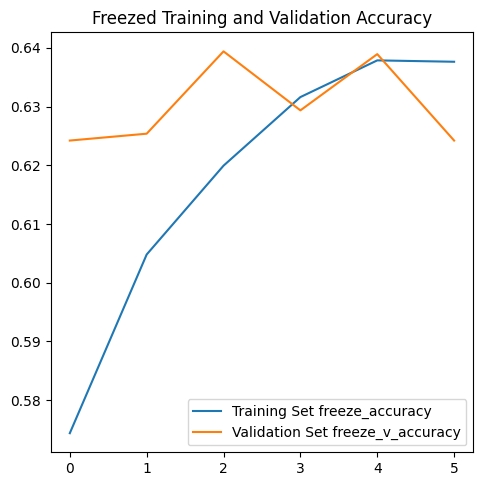

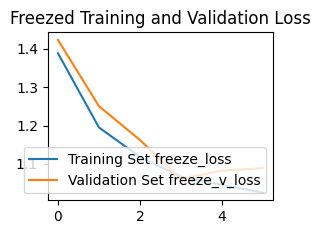

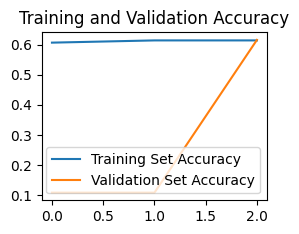

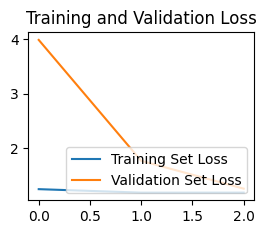

In [34]:
# Models Evaluation 
freeze_accuracy = history.history["acc"]
freeze_v_accuracy = history.history["val_acc"]

freeze_loss = history.history["loss"]
freeze_v_loss = history.history["val_loss"]

acc = fine_tuning_history.history["acc"]
v_acc = fine_tuning_history.history["val_acc"]

loss = fine_tuning_history.history["loss"]
v_loss = fine_tuning_history.history["val_loss"]

# Plot four main Evaluation criterions
epochs_10 = range(6)
epochs_3 = range(3)


plt.figure(figsize = (12, 12))
plt.subplot(2, 2, 1)
plt.plot(epochs_10, freeze_accuracy, label = "Training Set freeze_accuracy")
plt.plot(epochs_10, freeze_v_accuracy, label = "Validation Set freeze_v_accuracy")
plt.legend(loc = "lower right")
plt.title("Freezed Training and Validation Accuracy")
plt.show()

plt.subplot(2, 2, 2)
plt.plot(epochs_10, freeze_loss, label = "Training Set freeze_loss")
plt.plot(epochs_10, freeze_v_loss, label = "Validation Set freeze_v_loss")
plt.legend(loc = "lower right")
plt.title("Freezed Training and Validation Loss")
plt.show()

plt.subplot(2, 2, 3)
plt.plot(epochs_3, acc, label = "Training Set Accuracy")
plt.plot(epochs_3, v_acc, label = "Validation Set Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")
plt.show()

plt.subplot(2, 2, 4)
plt.plot(epochs_3, loss, label = "Training Set Loss")
plt.plot(epochs_3, v_loss, label = "Validation Set Loss")
plt.legend(loc = "lower right")
plt.title("Training and Validation Loss")
plt.show()

# Convert and save as tflite model

In [4]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/yq/qh4ny6ms3kz0yqqj4q2gqkn00000gn/T/tmp5u_wt902/assets


INFO:tensorflow:Assets written to: /var/folders/yq/qh4ny6ms3kz0yqqj4q2gqkn00000gn/T/tmp5u_wt902/assets


: 

: 

In [ ]:
# Save the model.
with open('my_model_pretrained_finetuned.tflite', 'wb') as f:
  f.write(tflite_model)

# Prediction

In [ ]:
preds = []
sample_sub_csv = pd.read_csv('data/sample_submission.csv')
classes = [ "Cassava Bacterial Blight (CBB)", 
           "Cassava Brown Streak Disease (CBSD)", 
           "Cassava Green Mottle (CGM)", 
           "Cassava Mosaic Disease (CMD)", 
           "Healthy" ]
for image in sample_sub_csv.image_id:
    img = tf.keras.preprocessing.image.load_img('data/test_images/' + image)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = tf.reshape(img, (-1, IMAGE_SIZE, IMAGE_SIZE, 3))
    prediction = custom_model_with_base_MobileNetV2.predict(img)
    print(f"prediction: {prediction}, type: {type(prediction)}, shape: {prediction.shape}")
    print(f"Class: {classes[np.argmax(prediction)]}")
    preds.append(np.argmax(prediction))

final_submission = pd.DataFrame({'image_id': sample_sub_csv.image_id, 'label': preds})
final_submission.to_csv('submission.csv', index=False) 

prediction: [[0.00491412 0.04006411 0.09978469 0.67050004 0.18473706]], 

type: <class 'numpy.ndarray'>, shape: (1, 5)


Class: Cassava Mosaic Disease (CMD)

prediction: [[0.02368715 0.03569924 0.01429282 0.8705369  0.0557838 ]], 

type: <class 'numpy.ndarray'>, shape: (1, 5)


Class: Cassava Mosaic Disease (CMD)